In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import  datasets, transforms

In [12]:
BATCH_SIZE = 512
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
pipeline=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,),(0.3081,))]
)

In [14]:
from torch.utils.data import DataLoader

train_set=datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=pipeline
)

test_set=datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=pipeline
)

train_loader=DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader=DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)


In [15]:
def train(model,device,train_loader,optimizer,epoch):
    model.train()
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target=data.to(device),target.to(device)
        # print(data.shape)
        optimizer.zero_grad()
        output=model(data)
        loss=F.cross_entropy(output,target)
        loss.backward()
        optimizer.step()
    # 把输出内容保存在 “CNN.txt” 文件中
    with open("../result/CNN.txt", "a") as f:
        f.write("Epoch: %d, Loss: %f\n" % (epoch, loss.item()))
        

In [16]:
def test(model,device,test_loader):
    model.eval()
    test_loss=0
    correct=0
    with torch.no_grad():
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            output=model(data)
            test_loss+=F.cross_entropy(output,target,reduction="sum").item()
            pred=output.max(1,keepdim=True)[1]
            correct+=pred.eq(target.view_as(pred)).sum().item()
    test_loss/=len(test_loader.dataset)
    with open("../result/CNN.txt", "a") as f:
        f.write("Test set: Average loss: %f, Accuracy: %d/%d (%f%%)\n" % (
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        ))
    

In [17]:
import time
def train_test(model,device,train_loader,test_loader,optimizer,epoch):
    for epoch in range(1,epoch+1):
        start=time.time()
        train(model,device,train_loader,optimizer,epoch)
        end=time.time()
        with open("../result/CNN.txt", "a") as f:
            f.write("Train Time:%.2f\n" % (end-start))
        start=time.time()
        test(model,device,test_loader)
        end=time.time()
        with open("../result/CNN.txt", "a") as f:
            f.write("Test Time:%.2f\n" % (end-start))
        # 保存模型
        torch.save(model.state_dict(), "../model/CNN.pth")

In [18]:
class ConvNet(nn.Module):
    
    def __init__(self,channels=32,kernel_conv1=5,kernel_conv3=3,kernel_pool1=2,kernel_pool2=2,
                 stride_pool1=2,stride_pool2=2,p=0.25,padding_conv1=2,padding_conv3=1,fc1_num=256):
        super(ConvNet, self).__init__()
        # 第一个卷积层   28+2*2-5+1=28,28+2*padding_conv1-kernel_conv1+1=num1
        self.kernel_conv1=kernel_conv1
        self.padding_conv1=padding_conv1
        self.kernel_conv3=kernel_conv3
        self.padding_conv3=padding_conv3
        self.kernel_pool1=kernel_pool1
        self.kernel_pool2=kernel_pool2
        self.stride_pool1=stride_pool1
        self.stride_pool2=stride_pool2
        self.p=p
        self.channels=channels
        self.fc1_num=fc1_num
        self.num1=28+2*padding_conv1-kernel_conv1+1
        self.num2=self.num1+2*padding_conv1-kernel_conv1+1
        self.num3=(self.num2+2*padding_conv1-kernel_conv1)//stride_pool1+1
        self.num4=self.num3+2*padding_conv3-kernel_conv3+1
        self.num5=self.num4+2*padding_conv3-kernel_conv3+1
        self.num6=(self.num5+2*padding_conv3-kernel_conv3)//stride_pool2+1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=kernel_conv1, padding=padding_conv1)
        # 第二个卷积层   28+2*2-5+1=28,num1+2*padding_conv1-kernel_conv1+1=num2
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_conv1, padding=padding_conv1)
        # 池化层 (28-2)/2+1=14, (num2-2*padding_conv1+kernel_conv1)/stride_pool1+1=num3
        self.pool = nn.MaxPool2d(kernel_size=kernel_pool1, stride=stride_pool1)
        # Dropout 
        self.dropout1 = nn.Dropout(p=p)
        # 第三个卷积层 14+1*2-5+1=14,num3+2*padding_conv3-kernel_conv3+1=num4
        self.conv3 = nn.Conv2d(in_channels=channels, out_channels=2*channels, kernel_size=kernel_conv3, padding=padding_conv3)
        # 第四个卷积层 14+1*2-3+1=14,num4+2*padding_conv3-kernel_conv3+1=num5
        self.conv4 = nn.Conv2d(in_channels=2*channels, out_channels=2*channels, kernel_size=kernel_conv3, padding=padding_conv3)
        # 第二个池化层 (14-2)/2+1=7, (num5-2*padding_conv3+kernel_conv3)/stride_pool2+1=num6
        self.pool2 = nn.MaxPool2d(kernel_size=kernel_pool2, stride=stride_pool2)
        # 第二个Dropout
        self.dropout2 = nn.Dropout(p=p)
        # 全连接层
        self.fc1 = nn.Linear(2*channels * self.num6 * self.num6, fc1_num)  # 64*4*4 是经过两次池化后的输出尺寸
        self.fc2 = nn.Linear(fc1_num, 10)

    def forward(self, x):
        # 应用第一个卷积层和ReLU激活函数
        x = F.relu(self.conv1(x))
        # 应用第二个卷积层和ReLU激活函数
        x = F.relu(self.conv2(x))
        # 应用池化层
        x = self.pool(x)
        # 应用Dropout
        x = self.dropout1(x)
        # 应用第三个卷积层和ReLU激活函数
        x = F.relu(self.conv3(x))
        # 应用第四个卷积层和ReLU激活函数
        x = F.relu(self.conv4(x))
        # 应用第二个池化层
        x = self.pool2(x)
        # 应用第二个Dropout
        x = self.dropout2(x)
        # 展平特征图
        # print(x.shape)
        x = x.view(-1, 2*self.channels * self.num6 * self.num6)
        # print(x.shape)
        # 应用第一个全连接层和ReLU激活函数
        x = F.relu(self.fc1(x))
        # 应用第二个全连接层和Softmax激活函数
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

class ConvNet_wo_pool(ConvNet):
    
    def __init__(self):
        super(ConvNet_wo_pool, self).__init__()

        self.num4=self.num2+2*self.padding_conv3-self.kernel_conv3+1
        self.num5=self.num4+2*self.padding_conv3-self.kernel_conv3+1
        self.fc1 = nn.Linear(2*self.channels * self.num5 * self.num5, self.fc1_num)  # 64*4*4 是经过两次池化后的输出尺寸
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 2*self.channels*self.num5 * self.num5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
        
class ConvNet_cut_layer(ConvNet):
    
    def __init__(self):
        super(ConvNet_cut_layer, self).__init__()
        self.fc1 = nn.Linear(self.channels * self.num3* self.num3, self.fc1_num)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(-1, self.channels* self.num3 * self.num3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
class ConvNet_average_pool(ConvNet):
    
    def __init__(self):
        super(ConvNet_average_pool, self).__init__()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.view(-1, 2*self.channels * self.num6 * self.num6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)


In [19]:
def run():
    
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("ConvNet_wo_pool(\n")
    # model=ConvNet_wo_pool().to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")  
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("ConvNet_average_pool(\n")
    # model=ConvNet_average_pool().to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # 
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("ConvNet_cut_layer(\n")
    # model=ConvNet_cut_layer().to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("p=0(\n")
    # model=ConvNet(p=0).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("p=0.125(\n")
    # model=ConvNet(p=0.125).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("p=0.5(\n")
    # model=ConvNet(p=0.5).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")

    EPOCHS=20
    with open("../result/CNN.txt", "a") as f:
        f.write("完整的(\n")
    model=ConvNet().to(DEVICE)
    optimizer=optim.Adam(model.parameters())
    train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    print("-----------------------------------------------------------")

    # with open("../result/CNN.txt", "a") as f:
    #     f.write("channels=16(\n")
    # model=ConvNet(channels=16).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("channels=8(\n")
    # model=ConvNet(channels=8).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")
    # 
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("fc1_num=128(\n")
    # model=ConvNet(fc1_num=128).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("fc1_num=64(\n")
    # model=ConvNet(fc1_num=64).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("fc1_num=32(\n")
    # model=ConvNet(fc1_num=32).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("kernel_conv1=3,padding_conv1=1(\n")
    # model=ConvNet(kernel_conv1=3,padding_conv1=1).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("kernel_conv1=7,padding_conv1=3(\n")
    # model=ConvNet(kernel_conv1=7,padding_conv1=3).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")
    # 
    # with open("../result/CNN.txt", "a") as f:
    #     f.write("kernel_conv1=9,padding_conv1=4(\n")
    # model=ConvNet(kernel_conv1=9,padding_conv1=4).to(DEVICE)
    # optimizer=optim.Adam(model.parameters())
    # train_test(model,DEVICE,train_loader,test_loader,optimizer,EPOCHS)
    # print("-----------------------------------------------------------")




In [20]:
if __name__ == "__main__":
    run()

-----------------------------------------------------------


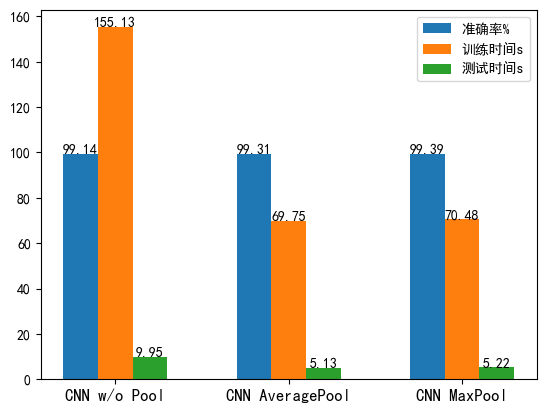

In [21]:

import matplotlib.pyplot as plt
import numpy as np
# 导入中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# 数据
categories = ['准确率%', '训练时间s', '测试时间s']
attributes = ['CNN w/o Pool', 'CNN AveragePool', 'CNN MaxPool']
value = [
    [99.14, 155.13, 9.95],  # 类别A的属性值
    [99.31, 69.75, 5.13],  # 类别B的属性值
    [99.39, 70.48, 5.22]   # 类别C的属性值
]
# values转置
values = np.array(value).T.tolist()

# 设置柱子的宽度
bar_width = 0.2

# 设置柱子的位置
index = np.arange(len(attributes))

# 绘制柱状图
# plt.figure(figsize=(10, 6))

# 绘制每个类别的柱状图
for i, category in enumerate(categories):
    plt.bar(index + i * bar_width, values[i], bar_width, label=category)

# 添加图例
plt.legend()

# 添加标题和标签
# plt.xlabel('属性')
# plt.ylabel('值')
# 设置字体大小
plt.xticks(fontsize=12)
plt.xticks(index + bar_width, attributes)
#具体数值
for x, y in enumerate(value):
    for i, j in enumerate(y):
        plt.text(x + bar_width * i, j + 0.1, '%.2f' % j, ha='center')
        
# 显示图表
plt.savefig("../result/池化CNN.svg")


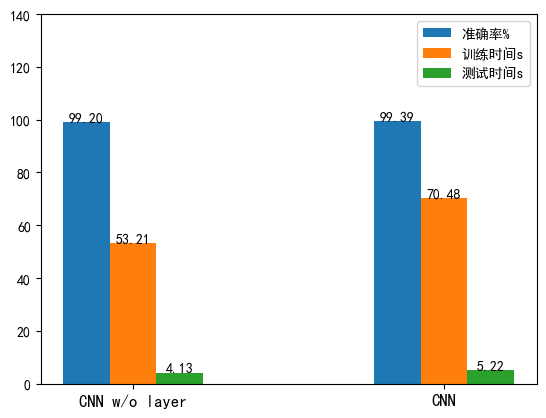

In [22]:
categories = ['准确率%', '训练时间s', '测试时间s']
attributes = ['CNN w/o layer', 'CNN']
value = [
    [99.20,99.39],  # 类别A的属性值
    [53.21, 70.48],  # 类别B的属性值
    [ 4.13, 5.22]   # 类别C的属性值
]

# 设置柱子的宽度
bar_width = 0.15
values = np.array(value).T.tolist()
# 设置柱子的位置
index = np.arange(len(attributes))

# 绘制柱状图
# plt.figure(figsize=(10, 6))
plt.ylim(0, 140)
plt.xticks(fontsize=12)
# 绘制每个类别的柱状图
for i, category in enumerate(categories):
    plt.bar(index + i * bar_width, value[i], bar_width, label=category)
# 添加图例
plt.legend()

# 添加标题和标签
# plt.xlabel('属性')
# plt.ylabel('值')
plt.xticks(index + bar_width, attributes)
#具体数值
for x, y in enumerate(values):
    for i, j in enumerate(y):
        plt.text(x + bar_width * i, j + 0.1, '%.2f' % j, ha='center')      
# 显示图表
plt.savefig("../result/cut_layerCNN.svg")

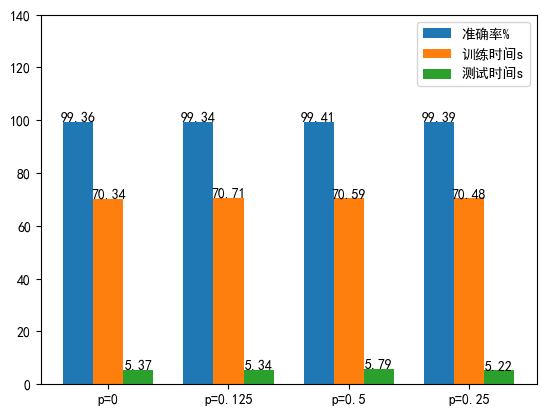

In [23]:

import matplotlib.pyplot as plt
import numpy as np
# 导入中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# 数据
categories = ['准确率%', '训练时间s', '测试时间s']
attributes = ['p=0','p=0.125', 'p=0.5', 'p=0.25']
value = [
    [99.36, 99.34,99.41,99.39 ],  # 类别A的属性值
    [70.34, 70.71,70.59, 70.48],  # 类别B的属性值
    [5.37,5.34, 5.79,5.22]   # 类别C的属性值
]
# values转置
values = np.array(value).T.tolist()

# 设置柱子的宽度
bar_width = 0.25

# 设置柱子的位置
index = np.arange(len(attributes))

# 绘制柱状图
# plt.figure(figsize=(10, 6))
plt.xticks(fontsize=10)
# 绘制每个类别的柱状图
for i, category in enumerate(categories):
    plt.bar(index + i * bar_width, value[i], bar_width, label=category)
# 添加图例
# 图例位置为右上，不占用图表空间
plt.legend(loc='upper right')

# y轴范围上升到120
plt.ylim(0, 140)

# 添加标题和标签
# plt.xlabel('属性')
# plt.ylabel('值')
plt.xticks(index + bar_width, attributes)
#具体数值
for x, y in enumerate(values):
    for i, j in enumerate(y):
        plt.text(x + bar_width * i, j + 0.1, '%.2f' % j, ha='center')
        
# 显示图表
plt.savefig("../result/p值CNN.svg")


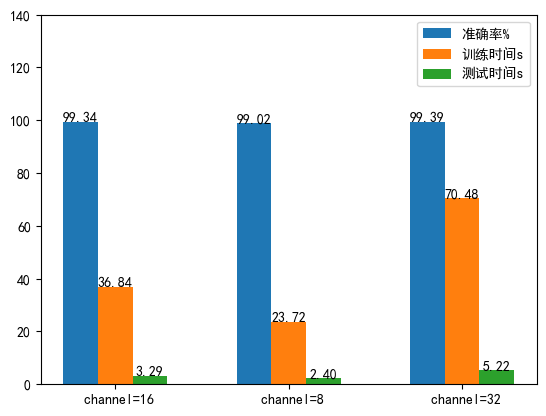

In [24]:

import matplotlib.pyplot as plt
import numpy as np
# 导入中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# 数据
categories = ['准确率%', '训练时间s', '测试时间s']
attributes = [' channel=16', ' channel=8', ' channel=32']
value = [
    [99.34, 99.02,99.39 ],  # 类别A的属性值
    [36.84, 23.72, 70.48],  # 类别B的属性值
    [3.29, 2.4, 5.22]   # 类别C的属性值
]
# values转置
values = np.array(value).T.tolist()

# 设置柱子的宽度
bar_width = 0.2

# 设置柱子的位置
index = np.arange(len(attributes))
plt.ylim(0, 140)
# 绘制柱状图
# plt.figure(figsize=(10, 6))
plt.xticks(fontsize=10)
# 绘制每个类别的柱状图
for i, category in enumerate(categories):
    plt.bar(index + i * bar_width, value[i], bar_width, label=category)
# 添加图例
plt.legend()

# 添加标题和标签
# plt.xlabel('属性')
# plt.ylabel('值')
plt.xticks(index + bar_width, attributes)
#具体数值
for x, y in enumerate(values):
    for i, j in enumerate(y):
        plt.text(x + bar_width * i, j + 0.1, '%.2f' % j, ha='center')
        
# 显示图表
plt.savefig("../result/channel值CNN.svg")


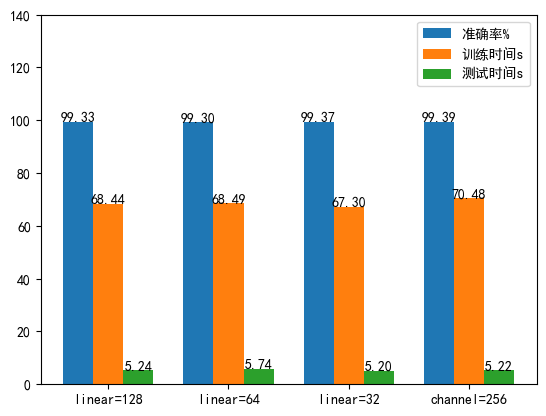

In [25]:

import matplotlib.pyplot as plt
import numpy as np
# 导入中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# 数据
categories = ['准确率%', '训练时间s', '测试时间s']
attributes = ['linear=128', 'linear=64', 'linear=32','channel=256']
value = [
    [99.33, 99.30,99.37,99.39 ],  # 类别A的属性值
    [68.44, 68.49, 67.30,70.48],  # 类别B的属性值
    [5.24, 5.74, 5.20,5.22]   # 类别C的属性值
]
# values转置
values = np.array(value).T.tolist()

# 设置柱子的宽度
bar_width = 0.25

# 设置柱子的位置
index = np.arange(len(attributes))

# 绘制柱状图


# 绘制每个类别的柱状图
for i, category in enumerate(categories):
    plt.bar(index + i * bar_width, value[i], bar_width, label=category)
# 添加图例
plt.legend()
plt.xticks(fontsize=10)
plt.ylim(0, 140)
plt.xticks(index + bar_width, attributes)
#具体数值
for x, y in enumerate(values):
    for i, j in enumerate(y):
        plt.text(x + bar_width * i, j + 0.1, '%.2f' % j, ha='center')
        
# 显示图表
plt.savefig("../result/linear值CNN.svg")


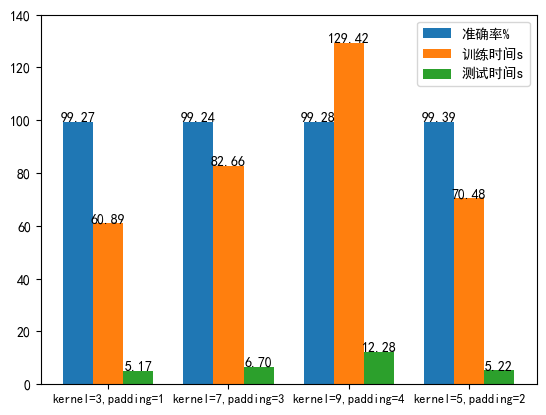

In [26]:

import matplotlib.pyplot as plt
import numpy as np
# 导入中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# 数据
categories = ['准确率%', '训练时间s', '测试时间s']
attributes = ['kernel=3,padding=1', 'kernel=7,padding=3',"kernel=9,padding=4", "kernel=5,padding=2"]
value = [
    [99.27, 99.24,99.28,99.39 ],  # 类别A的属性值
    [60.89, 82.66, 129.42,70.48],  # 类别B的属性值
    [5.17, 6.70, 12.28,5.22]   # 类别C的属性值
]
# values转置
values = np.array(value).T.tolist()

# 设置柱子的宽度
bar_width = 0.25

# 设置柱子的位置
index = np.arange(len(attributes))
plt.xticks(fontsize=9)
# 绘制柱状图
# plt.figure(figsize=(10, 6))
plt.ylim(0, 140)
# 绘制每个类别的柱状图
for i, category in enumerate(categories):
    plt.bar(index + i * bar_width, value[i], bar_width, label=category)
# 添加图例
plt.legend()

# 添加标题和标签
# plt.xlabel('属性')
# plt.ylabel('值')
plt.xticks(index + bar_width, attributes)
#具体数值
for x, y in enumerate(values):
    for i, j in enumerate(y):
        plt.text(x + bar_width * i, j + 0.1, '%.2f' % j, ha='center')
        
# 显示图表
plt.savefig("../result/kernel值CNN.svg")
